# TensorFlow Regression: Predict Wine Quality

#### Start

In [1]:
# Initial System Setup
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# tensorFlow Version
print(tf.__version__)

2.0.0


In [3]:
# import raw data if data has headers
raw_dataset = pd.read_csv('winequality-white.csv', sep=';')

In [4]:
dataset = raw_dataset.copy()

In [5]:
dataset.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


In [6]:
# Check if the dataset contains unknown values.

dataset.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [7]:
# drop those rows containing any values if any
dataset = dataset.dropna()

In [8]:
# Split the data into train and test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(len(train_dataset), len(test_dataset))

3918 980


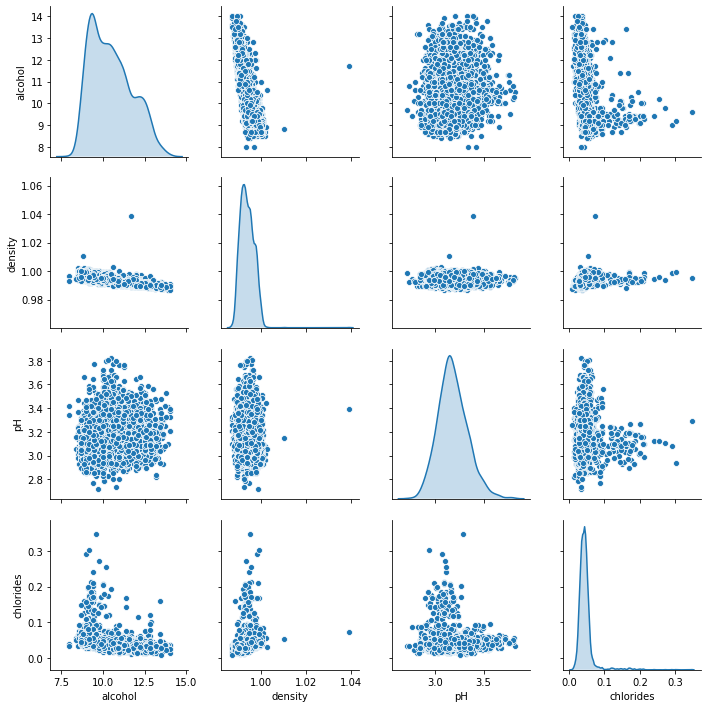

In [9]:
# Inspect the data
# Have a quick look at the joint distribution of a few pairs of columns from the training set.

sns.pairplot(train_dataset[["alcohol", "density", "pH", "chlorides"]], diag_kind="kde")

In [10]:
# Also look at the overall statistics
train_stats = train_dataset.describe()
train_stats.pop("quality")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3918.0,6.858754,0.855479,4.20000,6.300000,6.80000,7.3000,14.20000
volatile acidity,3918.0,0.278278,0.100173,0.08000,0.210000,0.26000,0.3200,1.00500
citric acid,3918.0,0.334722,0.122170,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,3918.0,6.380028,5.057262,0.60000,1.700000,5.20000,9.8500,65.80000
chlorides,3918.0,0.045709,0.022408,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,3918.0,35.172282,17.139453,2.00000,23.000000,34.00000,45.0000,289.00000
total sulfur dioxide,3918.0,137.688999,42.577736,9.00000,107.000000,133.50000,166.0000,440.00000
density,3918.0,0.994021,0.002987,0.98711,0.991753,0.99373,0.9961,1.03898
pH,3918.0,3.187412,0.151155,2.72000,3.080000,3.18000,3.2800,3.82000
sulphates,3918.0,0.489104,0.114159,0.23000,0.410000,0.47500,0.5500,1.08000


In [11]:
# Split features from labels
# Separate the target value, or "label", from the features. 
# This label is the value that you will train the model to predict.

train_labels = train_dataset.pop('quality')
test_labels = test_dataset.pop('quality')

In [12]:
# Normalize the data 

def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
# view the normalized data
# This normalized data is what we will use to train the model.
normed_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3918.0,8.877250e-16,1.0,-3.107913,-0.653148,-0.068680,0.515788,8.581444
volatile acidity,3918.0,-3.545460e-16,1.0,-1.979352,-0.681603,-0.182468,0.416493,7.254636
citric acid,3918.0,-2.357595e-16,1.0,-2.739798,-0.529767,-0.120502,0.452469,10.847799
residual sugar,3918.0,-7.616844e-17,1.0,-1.142917,-0.925408,-0.233333,0.686136,11.749436
chlorides,3918.0,-4.243670e-16,1.0,-1.638208,-0.433275,-0.120885,0.191505,13.401138
free sulfur dioxide,3918.0,-3.808422e-17,1.0,-1.935434,-0.710191,-0.068397,0.573397,14.809558
total sulfur dioxide,3918.0,-3.010467e-16,1.0,-3.022448,-0.720776,-0.098385,0.664925,7.100213
density,3918.0,-1.085219e-14,1.0,-2.313984,-0.759599,-0.097500,0.696015,15.052938
pH,3918.0,1.932321e-15,1.0,-3.092269,-0.710608,-0.049035,0.612537,4.185029
sulphates,3918.0,1.668452e-16,1.0,-2.269679,-0.692930,-0.123548,0.533431,5.176082


### The model

In [14]:
# Build the model

# a Sequential model with two densely connected hidden layers, & an output layer that returns a single, continuous value. 
# The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

def build_model():
    model = keras.Sequential([
       layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
       layers.Dense(64, activation='relu'),
       layers.Dense(1)])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [15]:
model = build_model()

In [16]:
# Inspect the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Now try out the model. 
# Take a batch of 10 examples from the training data and call model.predict on it.

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.14008063],
       [-0.05522717],
       [-0.02840211],
       [ 0.06489336],
       [ 0.02084336],
       [-0.63971317],
       [ 0.10860173],
       [-0.0313242 ],
       [ 0.12581876],
       [-0.3166072 ]], dtype=float32)

In [18]:
# Train the model
# Train the model for 1000 epochs,
# and record the training and validation accuracy in the history object.

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
    
EPOCHS = 1000
    
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [19]:
# View History
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.084793,0.223791,0.084793,0.785508,0.616802,0.785508,995
996,0.089344,0.226057,0.089344,0.783880,0.622898,0.783880,996
997,0.089223,0.228314,0.089223,0.778146,0.611055,0.778146,997
998,0.089965,0.229776,0.089965,0.830769,0.653446,0.830769,998
999,0.086605,0.226109,0.086605,0.817787,0.633909,0.817787,999


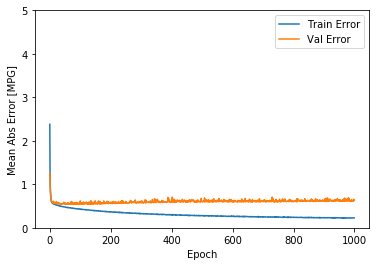

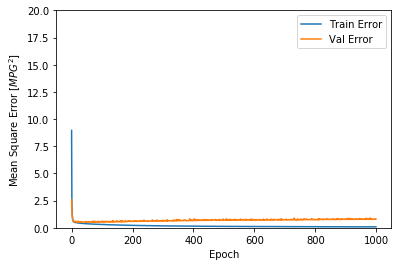

In [20]:
# Plot History

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()
    
    
plot_history(history)


..........................................

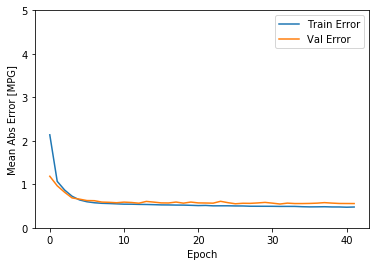

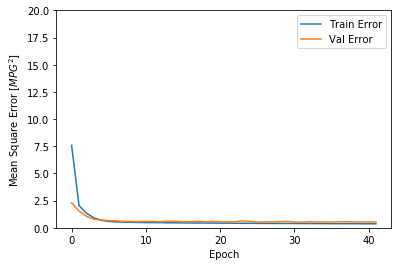

In [21]:
# Let's update the model.fit call to automatically stop training when the validation score doesn't improve.

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [22]:
# Let's see how well the model generalizes by using the test set,was not used when training the model. 
# This tells us how well we can expect the model to predict when we use it in the real world.

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} quality".format(mae))

980/980 - 0s - loss: 0.4898 - mae: 0.5401 - mse: 0.4898
Testing set Mean Abs Error:  0.54 quality


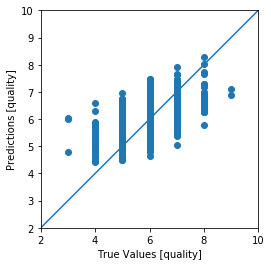

In [23]:
# Make predictions
# Finally, predict MPG values using data in the testing set:

test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [quality]')
plt.ylabel('Predictions [quality]')
lims = [2, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

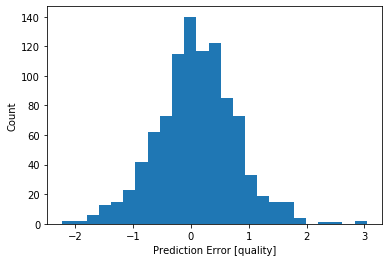

In [24]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [quality]")
_ = plt.ylabel("Count")

### Predictions By Example

In [25]:
# pick samples
i = 10
example_batch1 = normed_test_data[:i]
example_test_labels = test_labels[:i]

In [26]:
# test samples
example_batch1

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.165107,-0.082641,0.206910,2.831566,-0.031631,0.573397,0.758871,2.336614,-1.239866,-0.342541,-1.395444
7,0.165107,-0.082641,0.206910,2.831566,-0.031631,0.573397,0.758871,2.336614,-1.239866,-0.342541,-1.395444
21,-0.536254,0.316666,0.370616,-0.688125,-0.344021,-0.943570,-0.838208,-0.944585,-0.115193,-1.218513,0.393000
24,-0.302467,-0.082641,0.616175,-1.004502,0.280759,-1.118605,0.101250,0.361198,1.538739,-0.167347,-0.419929
25,0.165107,-0.282295,-0.120502,0.518061,0.012996,1.215192,2.520355,0.495125,0.414065,0.095445,-0.094757
28,0.632681,-0.082641,1.189146,-1.044049,0.057623,-1.060260,-0.133614,-0.877622,0.017122,0.007848,0.880758
32,0.632681,-0.282295,0.206910,-0.856200,0.191505,-0.243431,-0.885181,-0.676732,0.017122,-0.430138,0.230414
62,0.165107,1.913897,-2.166827,-1.044049,-0.477902,-1.060260,0.312628,-1.011549,-1.107552,-1.306110,-0.013464
63,-0.302467,1.015455,-1.512003,-0.351975,-0.076258,-0.593501,-1.401883,-0.308434,-0.512136,-0.955722,-0.257343
74,-0.185574,-0.481949,-0.202355,-0.846313,0.012996,-0.301776,-0.979127,-0.475843,0.943323,1.321805,0.149121


In [27]:
# test sample labels
example_test_labels

0     6
7     6
21    7
24    6
25    6
28    6
32    6
62    5
63    6
74    8
Name: quality, dtype: int64

In [28]:
# prediction
example_result = model.predict(example_batch1)
example_result

array([[5.1431828],
       [5.1431828],
       [6.1026473],
       [4.9022403],
       [5.8167133],
       [5.674759 ],
       [6.220279 ],
       [4.949231 ],
       [5.139261 ],
       [6.5023966]], dtype=float32)

In [29]:
# More accurate results
# rounding options (int, np.rint, np.ceil)
import numpy as np

for i in np.arange(len(example_result)):
    if np.ceil(example_result[i]) != np.array(example_test_labels)[i]:
        print('miss classification')
    else:
        print('Correct prediction')

Correct prediction
Correct prediction
Correct prediction
miss classification
Correct prediction
Correct prediction
miss classification
Correct prediction
Correct prediction
miss classification


### The End